## Second set of test runs - basic simulations, sparse fields where there is a mismeasurement of the PSFs (in terms of FWHM/shape/sigma).

This is an updated of "28. algorithm shootout - updated-dense.ipynb"

We will run it on increasingly dense fields (as in "28. algorithm shootout - vs stellar density using measured PSFs") but without mismeasurement of PSFs (just evaluate how the algorithms do in dense fields, all other issues aside).

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


In [2]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

In [4]:
def computeNormedPsfRms(psf1, psf2):
    psf1a = psf1.copy() / psf1.max()
    psf2a = psf2.copy() / psf2.max()
    weights = psf1a * psf2a   # instead of squaring either of them separately
    weights /= weights.mean()
    rms1weighted = np.sqrt(((psf1a - psf2a)**2. * weights).mean())
    return rms1weighted

# Clearly I did something to the SZOGY calculation! NEED TO FIX!

Looks like the estimate of the astrometric scintillation is bad. Set it to zero.

{'ZOGY': {'FP': 0, 'FN': 3, 'TP': 7}, 'ALstack': {'FP': 0, 'FN': 8, 'TP': 2}, 'SZOGY': {'FP': 2, 'FN': 3, 'TP': 7}, 'ALstack_noDecorr': {'FP': 0, 'FN': 6, 'TP': 4}}


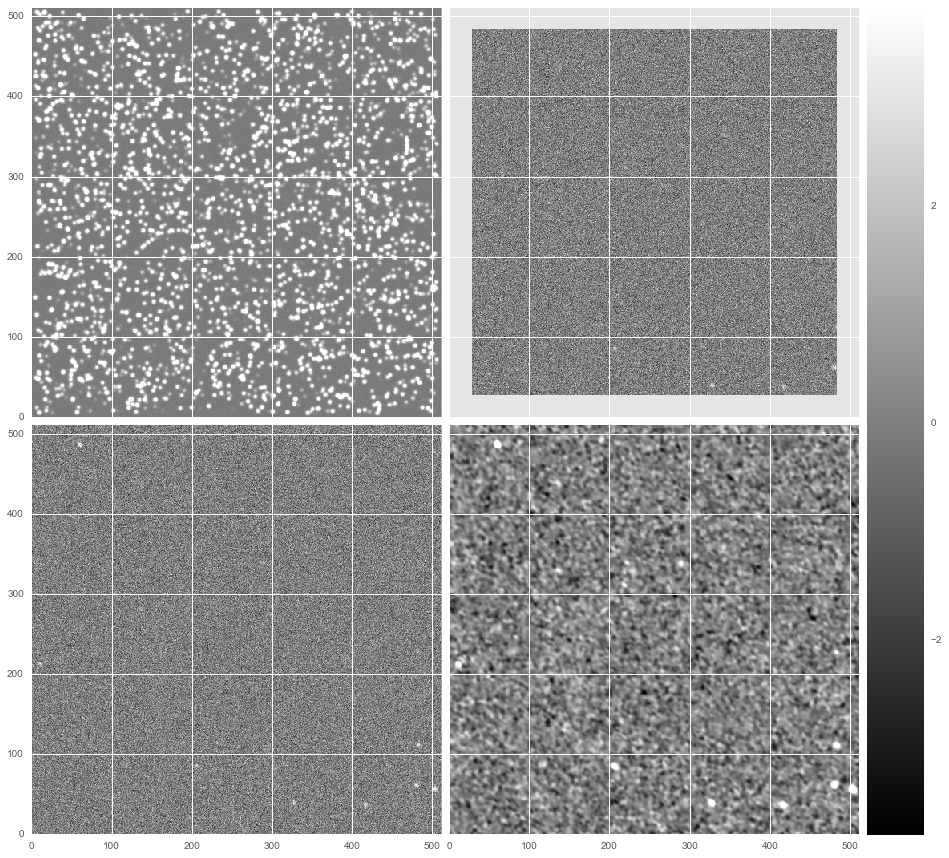

In [15]:
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         varFlux2=[500., 1000., 1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         theta1=0., theta2=-45., im2background=0., n_sources=3000, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=21, variablesNearCenter=False, avoidBorder=False)

testObj.astrometricOffsets[0] = testObj.astrometricOffsets[1] = 0.

det = testObj.runTest(zogyImageSpace=False)
print det

fig = plt.figure(1, (16, 16))
ret = testObj.doALInStack()
dit.plotImageGrid((testObj.im1.im, ret.decorrelatedDiffim, 
                   testObj.D_ZOGY.im, testObj.S_corr_ZOGY.im))

Try some real tests!

In [74]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=3000, n_varSources=10, #percentagePsfMismeasure=10.,
           scintillation=0., returnImages=False):
    #methods = ['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                             offset=[0,0], psf_yvary_factor=0., scintillation=scintillation,
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), seed=seed, psfSize=21, avoidBorder=False)
    #ppm = 1.0 + percentagePsfMismeasure / 100.
    #origPsf = testObj.im2.psf
    #testObj.im2.psf = dit.makePsf(psfSize=13, sigma=[1.8*ppm,2.2*ppm], theta=-45.*ppm)
    if scintillation == 0:
        testObj.astrometricOffsets[0] = testObj.astrometricOffsets[1] = 0.
    det = testObj.runTest(zogyImageSpace=True) #subtractMethods=methods) #, 'AL'])
    det['flux'] = flux
    #det['ppm'] = percentagePsfMismeasure
    #det['rms'] = np.sqrt(((origPsf - testObj.im2.psf)**2.).mean())
    #det['rms'] = computeNormedPsfRms(origPsf, testObj.im2.psf)
    det['nSources'] = n_sources
    if returnImages:
        det['testObj'] = testObj
    #print percentagePsfMismeasure, det['rms']
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

### Violin plots:
https://seaborn.github.io/generated/seaborn.violinplot.html#seaborn.violinplot

In [88]:
def plotResults(tr, methods=['ALstack', 'SZOGY']):
    TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
    FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})

    TP['nSources'] = np.array([t['nSources'] for t in tr])
    FP['nSources'] = np.array([t['nSources'] for t in tr])
    FN['nSources'] = np.array([t['nSources'] for t in tr])

    matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    tmp1 = TP[['nSources', methods[0]]]
    tmp2 = TP[['nSources', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'TP'
    tmp = pd.concat((tmp1, tmp2))
    #tmp['rms'] = np.round(tmp['rms'], 3)  # make it RMS instead of RMS

    g = sns.violinplot(x='nSources', y='TP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[0])
    g.set_title('True Positives')
    g.set_ylim((0, 52))
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

    tmp1 = FP[['nSources', methods[0]]]
    tmp2 = FP[['nSources', methods[1]]]
    tmp1['method'] = np.repeat(methods[0], tmp1.shape[0])
    tmp2['method'] = np.repeat(methods[1], tmp2.shape[0])
    tmp1.columns.values[1] = tmp2.columns.values[1] = 'FP'
    tmp = pd.concat((tmp1, tmp2))
    #tmp['rms'] = np.round(tmp['rms'], 3)

    g = sns.violinplot(x='nSources', y='FP', data=tmp, split=True, hue='method', inner="box", cut=0, 
                   linewidth=0.3, bw=0.5, ax=axes[1], width=0.98)
    g.set_title('False Positives')
    g.set_ylim((0, 15))
    g.set_xlabel('N sources')
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

In [80]:
tr = runTest(flux=1500, seed=66, n_sources=3000, n_varSources=50, returnImages=True)

{'SZOGY': {'FP': 2, 'FN': 11, 'TP': 39}, 'ALstack_noDecorr': {'FP': 1, 'FN': 17, 'TP': 33}, 'flux': 1500, 'ALstack': {'FP': 1, 'FN': 21, 'TP': 29}, 'nSources': 3000, 'ZOGY': {'FP': 1, 'FN': 12, 'TP': 38}}
[0.0, 0.0]


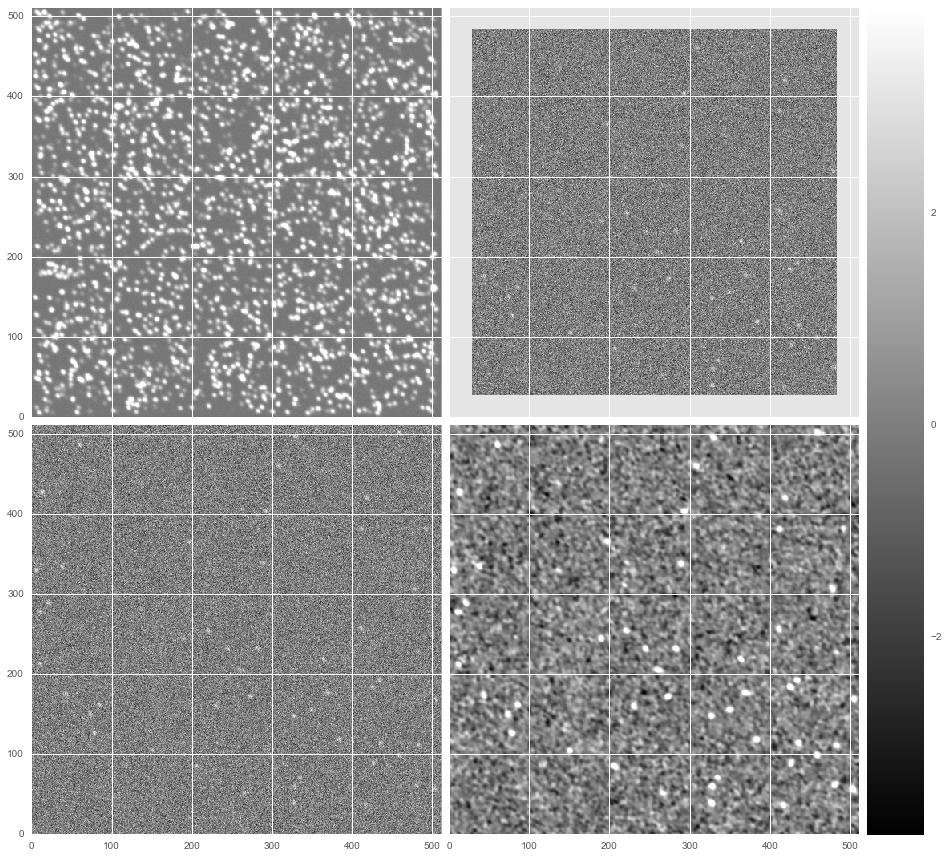

In [81]:
fig = plt.figure(1, (16, 16))
testObj = tr['testObj']
del tr['testObj']
print tr
print testObj.astrometricOffsets
#testObj.reset()
#det = testObj.runTest(zogyImageSpace=True)
#print det
ret = testObj.doALInStack()
dit.plotImageGrid((testObj.im2.im, ret.decorrelatedDiffim, 
                   testObj.D_ZOGY.im, testObj.S_corr_ZOGY.im))

## Look at detection rates for ~25-sigma sources.

Vary the number of static sources in the image. Note this test is for perfectly-fitted PSFs, just testing vs. density.

In [82]:
reload(dit)
#errorVals = [0,1,2,3,4,4.5,5,5.5,6,6.5,7,7.5,8,9,10,12,14,17,20]
#errorVals =  [0,  2,  4,          6,          8,  10,   13,16,20]
nSources = [10, 50, 100, 250, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
inputs = [(f, seed, ns) for f in [1500] for seed in np.arange(66, 166, 1) for ns in nSources]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=i[2]+50, 
                                                                      n_varSources=50) for i in inputs)
#testResults1 = [flux=runTest(i[0], seed=i[1], n_sources=i[2], n_varSources=50) for i in inputs]

1100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  8.1min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 39.4min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 91.9min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 154.6min
[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed: 234.9min
[Parallel(n_jobs=3)]: Done 1100 out of 1100 | elapsed: 256.3min finished


In [83]:
testResults1[1000]
#del testResults1
#import gc
#gc.collect()

{'ALstack': {'FN': 18, 'FP': 2, 'TP': 32},
 'ALstack_noDecorr': {'FN': 13, 'FP': 1, 'TP': 37},
 'SZOGY': {'FN': 13, 'FP': 8, 'TP': 37},
 'ZOGY': {'FN': 6, 'FP': 1, 'TP': 44},
 'flux': 1500,
 'nSources': 5050}

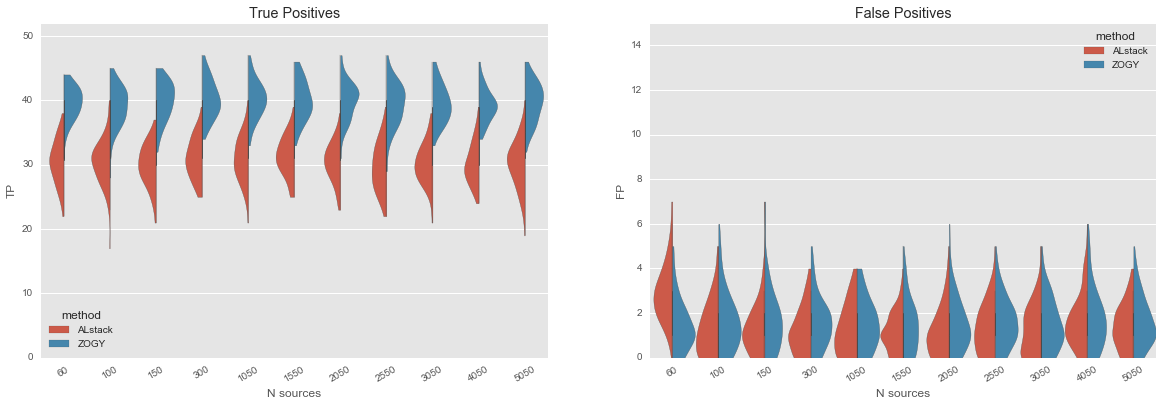

In [90]:
plotResults(testResults1, methods=['ALstack', 'ZOGY'])

In [85]:
import cPickle
import gzip
cPickle.dump((testResults1), gzip.GzipFile('testResults-28-dense.p.gz', 'wb'))